## Seismograms 101

In this exercise, we will download real seismic data and explore the data in the Fourier space.

In [ ]:
!pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 30.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import obspy
import numpy
import scipy

from obspy.clients.fdsn.client import Client 
from scipy.signal import decimate, butter,filtfilt
import matplotlib.pyplot as plt

import scipy.signal as signal

In [ ]:
client = Client("IRIS") # connect to IRIS earthquake service
R1=350 # radius the source
# provide times t1 at origin time and one hour after that 
t1 = obspy.UTCDateTime("2022-12-20") # for example obspy.UTCDateTime("2000-01-01T00:00:00") for 1/1/2000
t2 = t1+3600*24  # origin time + one hour in seconds
cat = client.get_events(starttime=t1, endtime=t2, minmagnitude=6)
# print(cat[0].origins[0])
# Main shock info:
Mag = cat[0].magnitudes[0].mag
print("Magnitude of the earthquale:",Mag)
t0 = cat[0].origins[0].time
print("origin time of the earthquake:",t0)
lat0 = cat[0].origins[0].latitude
lon0 = cat[0].origins[0].longitude
depth0 = cat[0].origins[0].depth/1000 # convert to km
print("Hypocenter of the earthquake:",lat0,lon0,depth0)

Magnitude of the earthquale: 6.4
origin time of the earthquake: 2022-12-20T10:34:24.770000Z
Hypocenter of the earthquake: 40.525 -124.423 17.91


In [ ]:
st=client.get_stations(network="UW",station="LEBA",location="*",channel="*Z",\
                       latitude=lat0,longitude=lon0,maxradius=R1/111.25,starttime=t0-1800,endtime=t0+86400,level="response")
print(st)

Inventory created at 2023-01-06T17:53:02.535800Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-12-20...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UO
		Stations (34):
			UO.BASIN (Brookings, OR, USA)
			UO.BENT (Myrtle Point, OR, USA)
			UO.CARP (Carpenterville, OR, USA)
			UO.CAVE (Cave Junction, OR, USA)
			UO.CHUCK (Harbor, OR, USA)
			UO.COQI (Coquille, OR, USA)
			UO.DAYS (Days Creek, OR, USA)
			UO.DBO (Dodson Butte, OR, USA)
			UO.DEAN (Reedsport, OR, USA)
			UO.DING (Powers, OR, USA)
			UO.DUTCH (Jacksonville, OR. USA)
			UO.HBUG (Ophir, OR, USA)
			UO.KBO (Bosley Butte, OR, USA)
			UO.KEB (Edson Butte, OR, USA)
			UO.KING (Golden, OR, USA)
			UO.LAIR (Myrtle Point, OR, USA)
			UO.LAKE (Lakeside, OR, USA)
			UO.LONE (Glide, OR, USA)
			UO.LOST (Merrill, OR, USA)
			UO.MERL (Merlin, OR, USA)
			UO.OLBLU (Kellogg, OR, USA)
			UO.RANT (Malin, OR, USA)
			UO.REDMO (Bro

We see above the available stations in the state of Oregon (still PNSN stations!). We see several channels that illustrate the types of instruments there are in a networks.

Let's just focus on BASIN. We will request all of the station metadata. Obspy return things in complex nested objects to have all of the information. We relaly want just tghe HN* data. We will download data just before and 2 hours after the origin time of the earthquake

In [ ]:
basin=client.get_stations(network="UO",station="BASIN",location="*",channel="HN*",\
                       starttime=t0-1800,endtime=t0+7200,level="response")

print(basin)
print(basin[0][0])  

Inventory created at 2023-01-06T18:10:13.187200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2022-12-20...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UO
		Stations (1):
			UO.BASIN (Brookings, OR, USA)
		Channels (3):
			UO.BASIN..HNZ, UO.BASIN..HNN, UO.BASIN..HNE
Station BASIN (Brookings, OR, USA)
	Station Code: BASIN
	Channel Count: 3/17 (Selected/Total)
	2022-05-27T00:00:00.000000Z - 
	Access: open 
	Latitude: 42.1795, Longitude: -124.1150, Elevation: 374.1 m
	Available Channels:
	    ..HN[ZNE]   200.0 Hz  2022-05-27 to None



* Z -> vertical
* N -> North
* E -> East

UO.BASIN..HN* is a strong motion sensor. Some more information here: https://pnsn.org/seismogram/current/basin
 It is set to low gain so that the instrument does not saturate (clip) in case of strong ground motions.

Let's download and plot the data.

UO BASIN


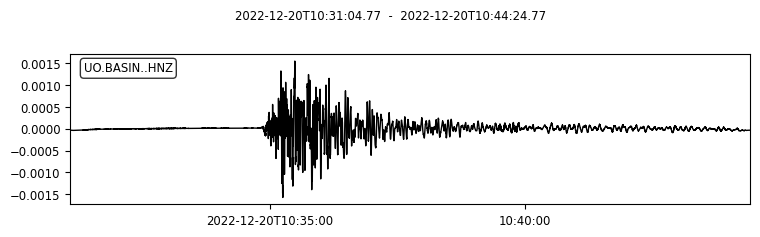

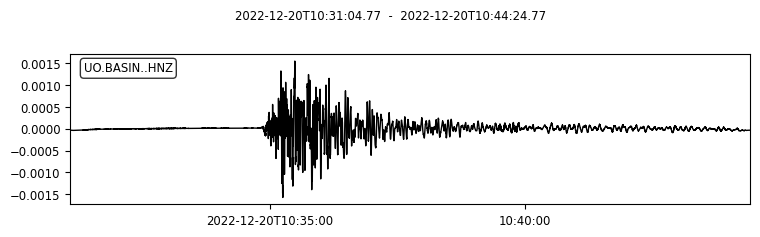

In [ ]:
net = basin[0].code
sta = basin[0][0].code
print(net,sta)
chan = "HNZ"
tr=client.get_waveforms(network=net,station=sta,channel=chan,location="*",starttime=t0-200,endtime=t0+600,attach_response=True);
tr.remove_response()
tr.plot() 

The data is in acceleration. Let's integrate to velocity and then displacement

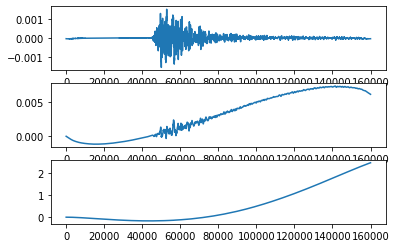

In [ ]:
from scipy.integrate import cumtrapz

acc = tr[0].data
vel = cumtrapz(acc)*tr[0].stats.delta
disp = cumtrapz(vel)*tr[0].stats.delta

fig,ax=plt.subplots(3,1)

ax[0].plot(acc)
ax[1].plot(vel)
ax[2].plot(disp)


Let's do the same analysis but in the frequency domain